In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import keras

In [2]:
def read_fasta(fasta_file):
    content = {}
    fas = open(fasta_file,'r')
    seq = ''
    last_entry = ''
    while True:
        line = fas.readline()
        if len(line)==0:
            content[last_entry]=seq
            break
        if '>' in line:
            if last_entry=='':
                line = line.rstrip()
                last_entry=line
            else:
                line = line.rstrip()
                content[last_entry]=seq
                last_entry=line
                seq=''
        else:
            line = line.rstrip()
            seq += line
    return content

In [4]:
tss = pd.read_csv('../data/original data/Start over ZJH/MTB TSS+-35bp sequence.csv')
data = pd.read_csv('../data/RPKM Mtb.csv').set_index('Unnamed: 0')
sample = pd.read_excel('../data/original data/Sample Mtb.xlsx').set_index('Run')
gff = pd.read_excel('../data/original data/Start over ZJH/mtb_gff.xls')
mtb_g = read_fasta('../data/original data/genome ref/Mycobacterium_tuberculosis_H37Rv_genome_v4.fasta')
gseq = mtb_g[list(mtb_g.keys())[0]]
info_df = pd.read_csv('../data/TP and feature Mtb_LGBM format.csv').set_index('gene')
tf = pd.read_excel('../data/original data/Nat Commun TF chipseq/TF_Chipseq_ncomms6829_MOESM46_ESM.xlsx',sheet_name='same_as_sheet1')

In [7]:
import conorm
normd = conorm.mrn(data)
tpv = np.log2(normd.values+1).std(axis=1)
median = np.median(np.log2(normd.values+1),axis=1)
tpv = pd.DataFrame({'TP':tpv,'Median':median},index=normd.index)

In [8]:
filtered = []
counts = tf.groupby('Regulator').count()
for x,c in zip(counts.index, counts['Gene']):
    if c>=20:
        filtered.append(tf[tf['Regulator']==x])
filtered = pd.concat(filtered)
regulators = filtered['Regulator'].unique()


In [16]:
#cds
gsize=len(gseq)
tf_table = []
tss_plus = np.sort(tss[tss['strand']=='+']['TSS.identifier'].values)
tss_minus = np.sort(tss[tss['strand']=='-']['TSS.identifier'].values)
c = 0
tp = []
nearest_tss = []
start_codon = []
genes = []
strand_sign = []
exp = []
gene_center = []
strand_list = []
for x in info_df.index:
    if x in gff['Locus'].values:
        start,end,strand = gff[gff['Locus']==x][['Start','Stop','Strand']].values[0]
        if strand == '+':
            start_codon.append(start)
            strand_sign.append(1)
            if start <100:
                gtss = tss_plus[-1]
            else:
                gtss = tss_plus[np.where((tss_plus-start)<10)[0][-1]]
        else:
            start_codon.append(end)
            gtss = tss_minus[np.where((tss_minus-end)>-10)[0][0]]
            strand_sign.append(-1)
        strand_list.append(strand)
        nearest_tss.append(gtss)
        genes.append(x)
        tp.append(tpv.loc[x,'TP'])
        exp.append(tpv.loc[x,'Median'])
        gene_center.append((start+end)/2)
tss_df = pd.DataFrame({'TP':tp,'TSS':nearest_tss,'Start_codon':start_codon,'Strand_sign':strand_sign,
                       'Expression':exp,'Center':gene_center,'Strand':strand_list},index=genes)

f1 = pd.read_csv('../data/original data/Start over ZJH/tss80_fourier.csv')
f1['label'] = [int(x.split('_')[1]) for x in f1['nameseq'].values]
f2 = pd.read_csv('../data/original data/Start over ZJH/tss80_entropy.csv')
f2['label'] = [int(x.split('_')[1]) for x in f2['0'].values]
f1 = f1.set_index('label')
f2 = f2.set_index('label')


f1_cols = list(f1.columns[1:])
f2_cols = list(f2.columns[1:-1])
#tss_df[f1_cols] = f1.loc[tss_df['TSS'].values][f1_cols].values
#tss_df[['CG_{}'.format(x) for x in f2_cols]] = f2.loc[tss_df['TSS'].values][f2_cols].values

In [26]:
for x in f1_cols:
    tss_df[x] = f1.loc[tss_df['TSS'].values][x].values
for x in f2_cols:
    tss_df['CG_{}'.format(x)] = f2.loc[tss_df['TSS'].values][x].values

In [32]:
f1_cols

['average',
 'median',
 'maximum',
 'minimum',
 'peak',
 'none_levated_peak',
 'sample_standard_deviation',
 'population_standard_deviation',
 'percentile15',
 'percentile25',
 'percentile50',
 'percentile75',
 'amplitude',
 'variance',
 'interquartile_range',
 'semi_interquartile_range',
 'coefficient_of_variation',
 'skewness',
 'kurtosis']

In [75]:
from scipy import stats

tf_tss_matrix_list = []
for site in ['TSS']:
    dist = (tss_df[site].values[:,np.newaxis]-filtered['Peak Center (Ccenter)'].values[np.newaxis,:])/100
    dist_binary = np.abs(dist)<100
    matched_sites = np.where(dist_binary)
    tf_tss_matrix = np.zeros((len(tss_df),len(regulators)))
    reg_dict = {k:i for i,k in enumerate(regulators)}
    for g,ri in np.array(matched_sites).T:
        reg = filtered['Regulator'].values[ri]
        if np.abs(dist[g,ri]<1):    
            tf_tss_matrix[g,reg_dict[reg]] +=3
        elif np.abs(dist[g,ri]<3):   
            tf_tss_matrix[g,reg_dict[reg]] +=2
        else:
            tf_tss_matrix[g,reg_dict[reg]] +=1
    tf_tss_matrix_list.append(tf_tss_matrix)
additional_features = info_df.loc[tss_df.index,info_df.columns[17:]].values
additional_features[pd.isna(additional_features)]=0
tf_tss_matrix_list=np.hstack(tf_tss_matrix_list+[additional_features]+[tss_df.values[:,7:26]])

feature_names = np.array(['{}_weight'.format(x) for x in regulators] +\
                         list(info_df.columns[17:]) +\
                         list(tss_df.columns[7:26]))
tf_tss_matrix_df = pd.DataFrame(tf_tss_matrix_list,columns=feature_names)

#tf_tss_matrix_list=np.hstack(tf_tss_matrix_list+[tss_df.values[:,7:]])
#tf_tss_matrix_list = additional_features

In [78]:
tf_tss_matrix_df

,Rv0022c_weight,Rv0023_weight,Rv0047c_weight,Rv0081_weight,Rv0135c_weight,Rv0158_weight,Rv0273c_weight,Rv0302_weight,Rv0324_weight,Rv0339c_weight,...,percentile25,percentile50,percentile75,amplitude,variance,interquartile_range,semi_interquartile_range,coefficient_of_variation,skewness,kurtosis
0,1,4,2,8,3,0,1,2,1,0,...,36.8864,53.3946,83.0718,1617.8,31712.4,46.1854,23.0927,2.21204,0.451033,0.230323
1,0,11,20,13,6,0,0,1,12,0,...,35.1042,50.4267,68.5546,1698.96,35499.7,33.4504,16.7252,2.34041,0.473848,0.146089
2,0,11,20,13,6,0,0,1,12,0,...,35.1042,50.4267,68.5546,1698.96,35499.7,33.4504,16.7252,2.34041,0.473848,0.146089
3,0,10,19,14,4,0,0,1,8,0,...,30.4685,51.8325,82.4847,1835.32,41061.3,52.0162,26.0081,2.51707,0.419647,0.266153
4,0,8,20,20,4,0,0,1,8,0,...,39.6617,50,81.1681,1723.8,36281.5,41.5064,20.7532,2.36604,0.475479,0.283145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,1,4,2,8,3,0,1,2,1,0,...,35.1045,51.4606,82.2831,1784.26,38671.4,47.1786,23.5893,2.44272,0.43813,0.333968
3867,1,4,2,8,3,0,1,2,1,0,...,35.1045,51.4606,82.2831,1784.26,38671.4,47.1786,23.5893,2.44272,0.43813,0.333968
3868,1,4,2,8,3,0,1,2,1,0,...,35.1045,51.4606,82.2831,1784.26,38671.4,47.1786,23.5893,2.44272,0.43813,0.333968
3869,1,4,2,8,3,0,1,2,1,0,...,35.1045,51.4606,82.2831,1784.26,38671.4,47.1786,23.5893,2.44272,0.43813,0.333968


In [81]:
tf_tss_matrix_list = tf_tss_matrix_list[:,np.where(tf_tss_matrix_list.sum(axis=0)!=0)[0]]

def minmax_norm(data):
    normd = (data-data.min(axis=0)[np.newaxis,:])/(data.max(axis=0)-data.min(axis=0))[np.newaxis,:]
    return normd

tf_tss_matrix_list = minmax_norm(tf_tss_matrix_list)

In [84]:
tf_tss_matrix_list

array([[0.07692307692307693, 0.21052631578947367, 0.07142857142857142,
        ..., 0.04395340448368324, 0.48314452396197455,
        0.4681768184182128],
       [0.0, 0.5789473684210527, 0.7142857142857143, ...,
        0.16669464099688544, 0.5326025486873678, 0.20546618648124593],
       [0.0, 0.5789473684210527, 0.7142857142857143, ...,
        0.16669464099688544, 0.5326025486873678, 0.20546618648124593],
       ...,
       [0.07692307692307693, 0.21052631578947367, 0.07142857142857142,
        ..., 0.2645250400785893, 0.4551732527052084, 0.7914226836775357],
       [0.07692307692307693, 0.21052631578947367, 0.07142857142857142,
        ..., 0.2645250400785893, 0.4551732527052084, 0.7914226836775357],
       [0.07692307692307693, 0.21052631578947367, 0.07142857142857142,
        ..., 0.2645250400785893, 0.4551732527052084, 0.7914226836775357]],
      dtype=object)

(1.0, 13.5)

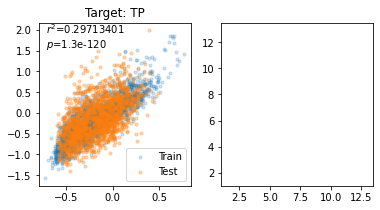

In [91]:
#tf_tss_matrix = tf_tss_matrix*tss_df['Strand_sign'].values[:,np.newaxis]
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

fig,axes = plt.subplots(figsize=(6,3),ncols=2,gridspec_kw={'wspace':0.2})
for i,f in enumerate(['TP','Expression']):
    if f=='TP':
        v = np.log2(tss_df[f].values)
    else:
        v = tss_df[f].values
    X_train,X_test,y_train,y_test = train_test_split(tf_tss_matrix_list,
                                                     v,
                                                     test_size=0.4,random_state=11)
    model = RandomForestRegressor(random_state=31,
                                  n_estimators=300,
                                  n_jobs=20,max_depth=10,
                                  max_features=100,
                                  min_samples_leaf=8)
    model.fit(X_train,y_train)
    
    
    axes[i].scatter(model.predict(X_train),y_train,s=10,alpha=0.2,label='Train',zorder=1)
    axes[i].scatter(model.predict(X_test),y_test,s=10,alpha=0.3,label='Test',zorder=100,)
    
    r,p = stats.pearsonr(model.predict(X_test),y_test)
    axes[i].text(0.05,0.85,'$r^2$={}\n$p$={:0.1e}'.format(round(r,4)**2,p),transform=axes[i].transAxes)
    axes[i].legend(loc=4)
    axes[i].set_title('Target: {}'.format(f))
    break
#axes[0].set_xlim(0,4)
#axes[0].set_ylim(0,4)
axes[1].set_xlim(1,13.5)
axes[1].set_ylim(1,13.5)

In [92]:
feature_names = np.array(['{}_weight'.format(x) for x in regulators] +\
                         list(info_df.columns[17:]) +\
                         list(tss_df.columns[7:]))
sorted_features = feature_names[np.flip(np.argsort(model.feature_importances_))]

(0.0, 10.0)

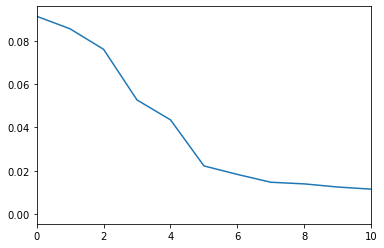

In [93]:
plt.plot(np.flip(np.sort(model.feature_importances_)))
plt.xlim(0,10)

In [94]:
sorted_features

array(['width', 'Activator.number', 'basePercent_GC', 'operon_length',
       'Rv3133c_weight', 'basePercent_G', 'X2.5..quantile.κ', 'GC3s',
       'AA_A', 'maxCov.TSS.MeanCoverage', 'G3s', 'percentile75', 'AA_C',
       'Geometric.mean.ω', 'basePercent_A', 'A3s', 'T3s', 'AA_G', 'AA_V',
       'Mean.Pr.ω.1.', 'AA_R', 'AA_L', 'l_beta', 'Nc',
       'X97.5..quantile.θ', 'basePercent_T', 'AA_D', 'Rv2034_weight',
       'C3s', 'sample_standard_deviation', 'AA_S', 'X97.5..quantile.κ',
       'median', 'maxCov.TSS.base_T', 'AA_Y', 'basePercent_C',
       'none_levated_peak', 'population_standard_deviation', 'gene_gamma',
       'Rv0047c_weight', 'Geometric.mean.κ', 'AA_H', 'Geometric.mean.θ',
       'maxCov.TSS.site', 'Rv3249c_weight', 'Aromo', 'Gravy',
       'semi_interquartile_range', 'AA_Q', 'maxCov.TSS.distance2gene',
       'AA_K', 'basePercent_CT', 'peak', 'X2.5..quantile.θ', 'AA_E',
       'AA_M', 'operon_innerLoc', 'CAI', 'amplitude', 'maximum', 'AA_N',
       'AA_F', 'skewness', 'n

In [581]:
[additional_features]+

(3871, 78)

In [586]:
info_df.columns[16:-20]

Index(['width', 'strand', 'AA_A', 'AA_C', 'AA_D', 'AA_E', 'AA_F', 'AA_G',
       'AA_H', 'AA_I', 'AA_K', 'AA_L', 'AA_M', 'AA_N', 'AA_P', 'AA_Q', 'AA_R',
       'AA_S', 'AA_T', 'AA_V', 'AA_W', 'AA_Y', 'basePercent_A',
       'basePercent_C', 'basePercent_T', 'basePercent_G', 'basePercent_GC',
       'basePercent_CT', 'T3s', 'C3s', 'A3s', 'G3s', 'CAI', 'CBI', 'Fop', 'Nc',
       'GC3s', 'Gravy', 'Aromo', 'Mean.Pr.ω.1.', 'X..sites.Pr.ω.1..90.',
       'Geometric.mean.ω', 'X2.5..quantile.geometric.mean.ω',
       'X97.5..quantile.geometric.mean.ω', 'Geometric.mean.θ',
       'X2.5..quantile.θ', 'X97.5..quantile.θ', 'Geometric.mean.κ',
       'X2.5..quantile.κ', 'X97.5..quantile.κ', 'operon_innerLoc',
       'operon_length', 'Rep.Direction', 'Rep.Transcript.Direction',
       'Repressor.number', 'Activator.number', 'RepressingTarget.number',
       'ActivatingTarget.number'],
      dtype='object')

In [535]:
def one_hot(seq,table={'A':3,'G':2,'C':1,'T':0}):
    return np.array([table[x] for x in seq.upper()])

def one_hot2D(seq,table={'A':3,'G':3,'C':0,'T':0}):
    arr = np.zeros((len(seq),4))
    for i,x in enumerate(seq.upper()):
        arr[i,table[x]]=1
    return arr

def reverse_complement(s):
    rc_dict = {'A':'T','T':'A','C':'G','G':'C','a':'t','t':'a','c':'g','g':'c'}
    comp = [rc_dict[x] for x in list(s)]
    comp.reverse()
    return ''.join(comp)

up = 60
down = 20

f = open('/Users/jzrolling/Desktop/Projects/Cheng_TP/tss_seq.fa','w')
pro_sequences = []

tsites = []
for i,(tsite,s) in enumerate(tss_df[['TSS','Strand']].values):
    if tsite not in tsites:
        tsites.append(tsite)
        g = tss_df.index[i]
        if s=='+':
            seq = gseq[(tsite-up):(tsite+down)]
        else:
            seq = reverse_complement(gseq[(tsite-down-1):(tsite+up-1)])
        pro_sequences.append(seq)
        f.write('>TSS_{}\n'.format(tsite))
        f.write('{}\n\n'.format(seq))
f.close()

ValueError: cannot reindex on an axis with duplicate labels

ValueError: cannot reindex on an axis with duplicate labels

In [553]:
f1_cols

Index(['average', 'median', 'maximum', 'minimum', 'peak', 'none_levated_peak',
       'sample_standard_deviation', 'population_standard_deviation',
       'percentile15', 'percentile25', 'percentile50', 'percentile75',
       'amplitude', 'variance', 'interquartile_range',
       'semi_interquartile_range', 'coefficient_of_variation', 'skewness',
       'kurtosis'],
      dtype='object')

In [529]:
tss_df

,TP,TSS,Start_codon,Strand_sign,Expression,Center,Strand
Rv0001,1.199355,4411270,1,1,8.649755,762.5,+
Rv0002,1.079817,1935,2052,1,7.633805,2656.0,+
Rv0003,1.008023,1935,3280,1,7.081369,3858.5,+
Rv0004,0.785344,3850,4434,1,6.989913,4715.5,+
Rv0005,0.759666,5183,5240,1,10.327431,6253.5,+
...,...,...,...,...,...,...,...
Rv3919c,1.166825,4411087,4408202,-1,8.483394,4407865.0,-
Rv3920c,1.318328,4411087,4408897,-1,9.979124,4408615.5,-
Rv3921c,1.230266,4411087,4410069,-1,9.698388,4409519.0,-
Rv3922c,1.500658,4411087,4410415,-1,9.144333,4410234.0,-


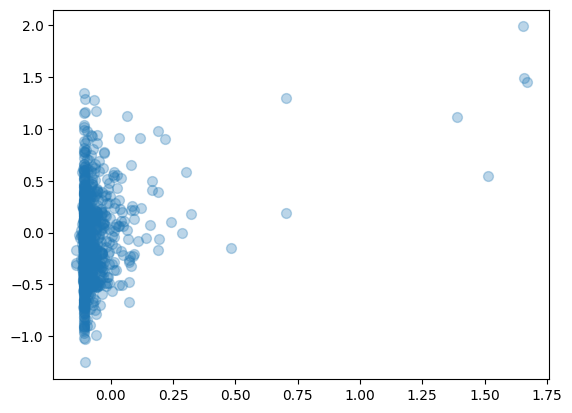

### 